# Importing libs and database files 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import pingouin as pg
import seaborn as sns
from modules import analysis
from itertools import combinations
import scikit_posthocs as sp

# Importing Data

In [2]:
# importint a csv file.
df_gklab = pd.read_csv('df_gkg-tms.csv')

# Fix the type of the 'context' column
df_gklab['context'] = df_gklab['context'].astype(pd.Int64Dtype())
df_gklab['context'] = df_gklab['context'].astype(str)
df_gklab['context'] = df_gklab['context'].replace('0', '00')

# Exclude volunteers if needed

In [3]:
lst_excluded_volunteers = []

df_gklab = df_gklab[~df_gklab['ID_info'].isin(lst_excluded_volunteers)]

# Success Rate Analysis
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

         W   pval  normal
1.0  0.905  0.095    True
2.0  0.810  0.004   False
3.0  0.774  0.001   False
4.0  0.746  0.001   False
5.0  0.897  0.073    True
6.0  0.955  0.577    True


/home/victormoraes/Documents/GitHub/TMS-GoalkeeperGame/modules/analysis.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_rates = group.groupby('block_info').apply(
/home/victormoraes/Documents/GitHub/TMS-GoalkeeperGame/modules/analysis.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_rates = group.groupby('block_info').apply(
/home/victormoraes/Documents/GitHub/TMS-GoalkeeperGame/modules/ana

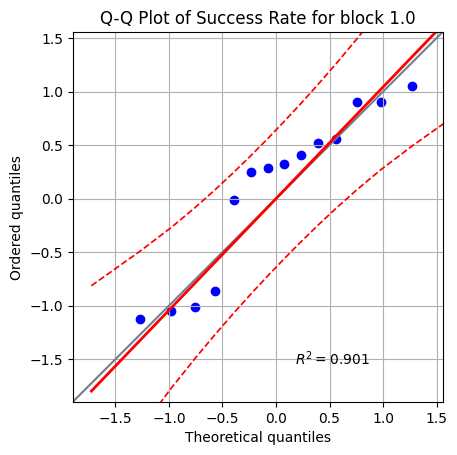

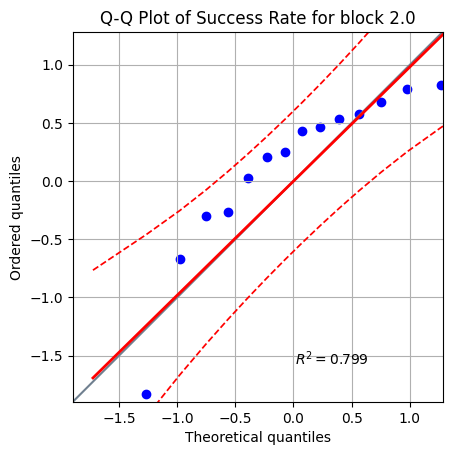

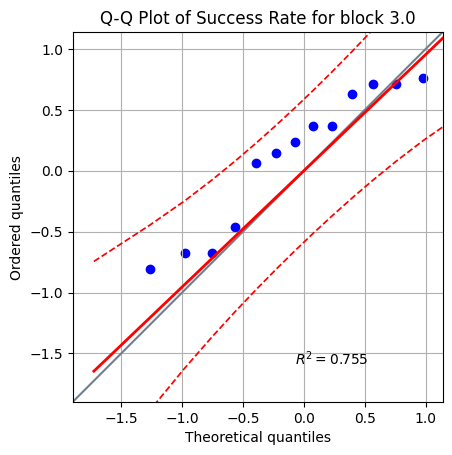

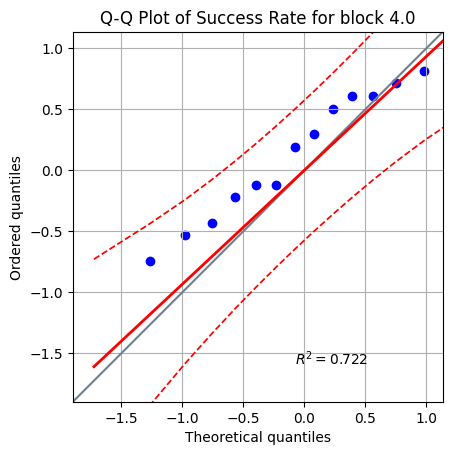

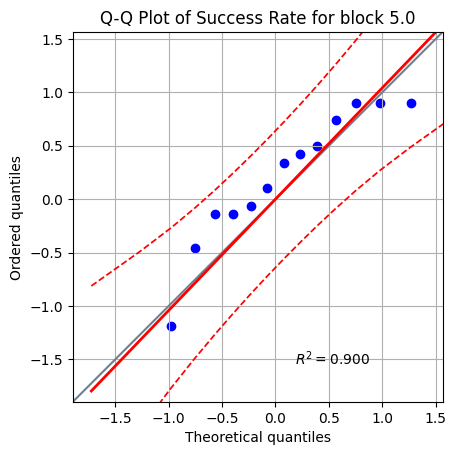

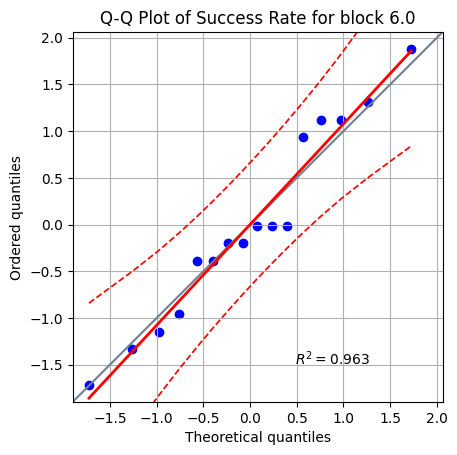

In [4]:
# Calculating mean values of subjects
success_rate_blocks = analysis.calculate_success_rate_by_block_group(df_gklab)

# Convert the dictionary to a DataFrame
success_rate_blocks_df = pd.DataFrame.from_dict(success_rate_blocks, orient='index')

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(success_rate_blocks_df)
print(shapiro_results.round(3))

# Q-Q plots for each block
for column in success_rate_blocks_df.columns:
    plt.figure()  # Create a new figure for each column
    pg.qqplot(success_rate_blocks_df[column], dist='norm')
    plt.title(f'Q-Q Plot of Success Rate for block {column}')
    plt.grid(True)
    plt.show()

# # Histograms for each block
# for column in success_rate_blocks_df.columns:
#     plt.figure()  # Create a new figure for each column
#     sns.histplot(success_rate_blocks_df[column], kde=True)
#     plt.title(f'Histogram of Success Rate for block {column}')
#     plt.xlabel('Success Rate')
#     plt.ylabel('Frequency')
#     plt.show()

In [5]:
# Convert wide format to long format
success_rate_blocks_df = success_rate_blocks_df.melt(var_name='Block', value_name='SuccessRate')

# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=success_rate_blocks_df, 
                          dv='SuccessRate', 
                          between='Block')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = success_rate_blocks_df['Block'].nunique()
n = len(success_rate_blocks_df)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(success_rate_blocks_df, val_col='SuccessRate', group_col='Block', p_adjust='fdr_bh') # Benjamini/Hochberg (non-negative) ‘fdr_bh’
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
        Source  ddof1       H  p-unc
Kruskal  Block      5  25.651    0.0

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.2295

Dunn's Post Hoc Test Results:
       1.0    2.0    3.0    4.0    5.0    6.0
1.0  1.000  0.057  0.036  0.002  0.000  0.000
2.0  0.057  1.000  0.807  0.327  0.172  0.095
3.0  0.036  0.807  1.000  0.441  0.249  0.143
4.0  0.002  0.327  0.441  1.000  0.746  0.498
5.0  0.000  0.172  0.249  0.746  1.000  0.746
6.0  0.000  0.095  0.143  0.498  0.746  1.000


# Response Time in different Buttons Analysis
- Normality and Homocedasticity Tests
- ANOVA one way

In [ ]:
# Calculate mean response times grouped by ID_info and response_info and plot RTs by Responses
mean_response_times_by_responses = df_gklab.groupby(['ID_info', 'response_info'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_by_responses, dv='response_time_info', group='response_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_by_responses, dv='response_time_info', group='response_info')
print(levene_results.round(3))

# Q-Q plots for each response category
response_categories = mean_response_times_by_responses['response_info'].unique()
for response in response_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_by_responses[mean_response_times_by_responses['response_info'] == response]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for Response {response}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for response in response_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_by_responses[mean_response_times_by_responses['response_info'] == response]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for Response {response}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_by_responses, dv='response_time_info', between='response_info', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))

In [ ]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_by_responses, 
                          dv='response_time_info', 
                          between='response_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_by_responses, val_col='response_time_info', group_col='response_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

# Response Time by Blocks Analysis
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

In [ ]:
# Calculate mean response times grouped by ID_info and block_info and plot RTs by Blocks
mean_response_times_by_blocks = df_gklab.groupby(['ID_info', 'block_info'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_by_blocks, dv='response_time_info', group='block_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_by_blocks, dv='response_time_info', group='block_info')
print(levene_results.round(3))

# Q-Q plots for each response category
block_categories = mean_response_times_by_blocks['block_info'].unique()
for block in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_by_blocks[mean_response_times_by_blocks['block_info'] == block]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for Block {block}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for block in block_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_by_blocks[mean_response_times_by_blocks['block_info'] == block]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for Block {block}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_by_blocks, 
                          dv='response_time_info', 
                          between='block_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_response_times_by_blocks['block_info'].nunique()
n = len(mean_response_times_by_blocks)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_by_blocks, val_col='response_time_info', group_col='block_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

In [ ]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_by_blocks, dv='response_time_info', between='block_info', detailed=True)

# Print the ANOVA results
print(anova_results)
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_by_blocks, 
                                         dv='response_time_info', 
                                         between='block_info', 
                                         padjust='fdr_bh')
    print(posthoc_results)
    
else:
    print("No significant differences found; no post hoc analysis needed.")

# Response times with and without TMS pulses
- Normality test
- Unpaired T test

In [ ]:
# Calculate mean response times grouped by ID_info and TMS pulse
mean_response_times_NoPulse_Pulse = df_gklab.groupby(['ID_info', 'tms_pulse'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_NoPulse_Pulse, dv='response_time_info', group='tms_pulse')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_NoPulse_Pulse, dv='response_time_info', group='tms_pulse')
print(levene_results.round(3))

# Q-Q plots for each response category
pulse_categories = mean_response_times_NoPulse_Pulse['tms_pulse'].unique()
for i in pulse_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for TMS Pulse {i}')
    plt.grid(True)
    plt.show()
    
# # Histograms for each response category
# for i in pulse_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for TMS Pulse {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
# Get x and y from dataframe
rt_with_tms = mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == 'Pulse']['response_time_info']
rt_without_tms = mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == 'noPulse']['response_time_info']

# Perform T test
ttest_results = pg.ttest(rt_with_tms, rt_without_tms, correction=False, paired=False)
print(ttest_results.round(3))

# Response Time by Contexts during TMS pulses
- Normality test
- ANOVA with pairwise T tests and Benjamini/Hochberg correction

In [ ]:
# Filter RTs during pulses
rt_pulse_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'Pulse') & (df_gklab['context'] != '<NA>')]

# Get Mean Response Times by Contexts and Plot   
mean_response_times_pulse_ctx = rt_pulse_df.groupby(['ID_info', 'context'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_pulse_ctx, dv='response_time_info', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_pulse_ctx, dv='response_time_info', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_response_times_pulse_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_pulse_ctx[mean_response_times_pulse_ctx['context'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_pulse_ctx[mean_response_times_pulse_ctx['context'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for context {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_pulse_ctx, dv='response_time_info', between='context', detailed=True)

# Print the ANOVA results
print(anova_results)
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_pulse_ctx, 
                                         dv='response_time_info', 
                                         between='context', 
                                         padjust='fdr_bh')
    print(posthoc_results)
    
else:
    print("No significant differences found; no post hoc analysis needed.")

In [ ]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_pulse_ctx, 
                          dv='response_time_info', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_response_times_pulse_ctx['context'].nunique()
n = len(mean_response_times_pulse_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_pulse_ctx, val_col='response_time_info', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

# Response Time by Contexts without TMS pulses
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

In [ ]:
# Filter RTs during pulses
rt_nopulse_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'noPulse') & (df_gklab['context'] != '<NA>')]

# Get Mean Response Times by Contexts and Plot   
mean_response_times_nopulse_ctx = rt_nopulse_df.groupby(['ID_info', 'context'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_nopulse_ctx, dv='response_time_info', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_nopulse_ctx, dv='response_time_info', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_response_times_nopulse_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_nopulse_ctx[mean_response_times_nopulse_ctx['context'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_nopulse_ctx[mean_response_times_nopulse_ctx['context'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for context {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_nopulse_ctx, dv='response_time_info', between='context', detailed=True)

# Print the ANOVA results
print(anova_results)
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_nopulse_ctx, 
                                         dv='response_time_info', 
                                         between='context', 
                                         padjust='fdr_bh')
    print(posthoc_results)
    
else:
    print("No significant differences found; no post hoc analysis needed.")

In [ ]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_nopulse_ctx, 
                          dv='response_time_info', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_response_times_nopulse_ctx['context'].nunique()
n = len(mean_response_times_nopulse_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_nopulse_ctx, val_col='response_time_info', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

# Response Time by Contexts with all RTs (n=1200)
- Normality test
- ANOVA with pairwise T test and Benjamini/Hochberg correction

In [ ]:
# Filter RTs
rt_df = df_gklab.loc[(df_gklab['context'] != '<NA>')]

# Get Mean Response Times by Contexts
mean_response_times_ctx = rt_df.groupby(['ID_info', 'context'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_ctx, dv='response_time_info', group='context')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_ctx, dv='response_time_info', group='context')
print(levene_results.round(3))

# Q-Q plots for each response category
ctx_categories = mean_response_times_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_ctx[mean_response_times_ctx['context'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_ctx[mean_response_times_ctx['context'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for context {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_ctx, dv='response_time_info', between='context', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_ctx, 
                                         dv='response_time_info', 
                                         between='context', 
                                         padjust='fdr_bh')
    print(posthoc_results.round(3))
    
else:
    print("No significant differences found; no post hoc analysis needed.")

# Diference between error and success by Contexts during TMS pulse Analysis
- Normality test
- Wilcoxon signed rank test with Benjamini-Hochberg correction or T-Test with Benjamini/Hochberg Correction

In [ ]:
# Get Mean Response Times by Contexts and Plot   
mean_response_times_ctx_prevresult = rt_pulse_df.groupby(['ID_info', 'context', 'last_was_error'])['response_time_info'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_response_times_ctx_prevresult,
                            values='response_time_info',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of Mean Difference of RTs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of Response Times Mean Difference for context {i}')
#     plt.xlabel('Response Time Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()


In [ ]:
### Using Wilcoxon signed rank test with Benjamini-Hochberg correction

from statsmodels.stats.multitest import multipletests

# Assuming stacked_df is your DataFrame
results_list = []
p_values = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    results = pg.wilcoxon(context_data['mean_difference'], context_data['reference'])
    
    # Collect p-value for Benjamini-Hochberg correction
    p_values.append(results['p-val'].iloc[0])
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'W': results['W-val'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'alternative': results['alternative'].iloc[0],
        'RBC': results['RBC'].iloc[0],
        'CLES': results['CLES'].iloc[0]
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini-Hochberg correction
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = adjusted_p_values

results_df.round(3)

In [ ]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df.round(3)


# Diference between error and success by Contexts without TMS pulse Analysis
- Normality test
- Wilcoxon signed rank test with Benjamini-Hochberg correction

In [ ]:
# Get Mean Response Times by Contexts and Plot   
mean_response_times_ctx_prevresult = rt_nopulse_df.groupby(['ID_info', 'context', 'last_was_error'])['response_time_info'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_response_times_ctx_prevresult,
                            values='response_time_info',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of Mean Difference of RTs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of Response Times Mean Difference for context {i}')
#     plt.xlabel('Response Time Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()


In [ ]:
### Using Wilcoxon signed rank test with Benjamini-Hochberg correction

from statsmodels.stats.multitest import multipletests

# Assuming stacked_df is your DataFrame
results_list = []
p_values = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    results = pg.wilcoxon(context_data['mean_difference'], context_data['reference'])
    
    # Collect p-value for Benjamini-Hochberg correction
    p_values.append(results['p-val'].iloc[0])
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'W': results['W-val'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'alternative': results['alternative'].iloc[0],
        'RBC': results['RBC'].iloc[0],
        'CLES': results['CLES'].iloc[0]
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini-Hochberg correction
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = adjusted_p_values

results_df.round(3)

In [ ]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df.round(3)

# Diference between error and success by Contexts with all RTs (n = 1200)
- Normality test
- ANOVA

In [ ]:
# Get Mean Response Times by Contexts and Plot   
mean_all_response_times_ctx_prevresult = rt_df.groupby(['ID_info', 'context', 'last_was_error'])['response_time_info'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_all_response_times_ctx_prevresult,
                            values='response_time_info',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of Mean Difference of RTs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of Response Times Mean Difference for context {i}')
#     plt.xlabel('Response Time Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
### Using Wilcoxon signed rank test with Benjamini-Hochberg correction

from statsmodels.stats.multitest import multipletests

# Assuming stacked_df is your DataFrame
results_list = []
p_values = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    results = pg.wilcoxon(context_data['mean_difference'], context_data['reference'])
    
    # Collect p-value for Benjamini-Hochberg correction
    p_values.append(results['p-val'].iloc[0])
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'W': results['W-val'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'alternative': results['alternative'].iloc[0],
        'RBC': results['RBC'].iloc[0],
        'CLES': results['CLES'].iloc[0]
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini-Hochberg correction
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = adjusted_p_values

results_df.round(3)

In [ ]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df.round(3)

# MEP differences between blocks
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

In [ ]:
# Filter MEPs during pulses
meps_blocks_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'Pulse')]

# Calculate mean FDI MEPs grouped by ID_info and block_info
mean_FDImeps_by_blocks = meps_blocks_df.groupby(['ID_info', 'block_info'])['relMean_MEPpp_FDI'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_FDImeps_by_blocks, dv='relMean_MEPpp_FDI', group='block_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_FDImeps_by_blocks, dv='relMean_MEPpp_FDI', group='block_info')
print(levene_results.round(3))

# Q-Q plots for each MEP block
block_categories = mean_FDImeps_by_blocks['block_info'].unique()
for i in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_FDImeps_by_blocks[mean_FDImeps_by_blocks['block_info'] == i]['relMean_MEPpp_FDI'], dist='norm')
    plt.title(f'Q-Q Plot of MEPs for block {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in block_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_FDImeps_by_blocks[mean_FDImeps_by_blocks['block_info'] == i]['relMean_MEPpp_FDI'], kde=True)
#     plt.title(f'Histogram of FDI MEPs for block {i}')
#     plt.xlabel('FDI MEPs')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_FDImeps_by_blocks, 
                          dv='relMean_MEPpp_FDI', 
                          between='block_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_FDImeps_by_blocks['block_info'].nunique()
n = len(mean_FDImeps_by_blocks)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_by_blocks, val_col='relMean_MEPpp_FDI', group_col='block_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

# FDI MEP difference between responses

In [ ]:
# Calculate mean FDI MEPs grouped by ID_info and response_info
mean_FDImeps_by_response = meps_blocks_df.groupby(['ID_info', 'response_info'])['relMean_MEPpp_FDI'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_FDImeps_by_response, dv='relMean_MEPpp_FDI', group='response_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_FDImeps_by_response, dv='relMean_MEPpp_FDI', group='response_info')
print(levene_results.round(3))

# Q-Q plots for each MEP block
block_categories = mean_FDImeps_by_response['response_info'].unique()
for i in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_FDImeps_by_response[mean_FDImeps_by_response['response_info'] == i]['relMean_MEPpp_FDI'], dist='norm')
    plt.title(f'Q-Q Plot of MEPs for block {i}')
    plt.grid(True)
    plt.show()

In [ ]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_FDImeps_by_response, 
                          dv='relMean_MEPpp_FDI', 
                          between='response_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_FDImeps_by_response['response_info'].nunique()
n = len(mean_FDImeps_by_response)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_FDImeps_by_response, val_col='relMean_MEPpp_FDI', group_col='response_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

# FDI MEP differences by contexts
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

In [ ]:
# Filter MEPs during pulses
meps_blocks_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'Pulse') & (df_gklab['context'] != '<NA>')]

# Get Mean FDI MEPs relative to mean by Contexts    
mean_relmFDImepsmean_ctx = meps_blocks_df.groupby(['ID_info', 'context'])['relMean_MEPpp_FDI'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_relmFDImepsmean_ctx, dv='relMean_MEPpp_FDI', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_relmFDImepsmean_ctx, dv='relMean_MEPpp_FDI', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_relmFDImepsmean_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_relmFDImepsmean_ctx[mean_relmFDImepsmean_ctx['context'] == i]['relMean_MEPpp_FDI'], dist='norm')
    plt.title(f'Q-Q Plot of FDI MEPs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_relmFDImepsmean_ctx[mean_relmFDImepsmean_ctx['context'] == i]['relMean_MEPpp_FDI'], kde=True)
#     plt.title(f'Histogram of FDI MEPs for context {i}')
#     plt.xlabel('FDI MEPs')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_relmFDImepsmean_ctx, dv='relMean_MEPpp_FDI', between='context', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))
print("\n")

# Perform post hoc tests with Benjamini/Hochberg correction
posthoc_results = pg.pairwise_tests(data=mean_relmFDImepsmean_ctx, 
                                     dv='relMean_MEPpp_FDI', 
                                     between='context', 
                                     padjust='fdr_bh')

# Print the post hoc results
print(posthoc_results.round(3))

In [ ]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_relmFDImepsmean_ctx, 
                          dv='relMean_MEPpp_FDI', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_relmFDImepsmean_ctx['context'].nunique()
n = len(mean_relmFDImepsmean_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_relmFDImepsmean_ctx, val_col='relMean_MEPpp_FDI', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

# FDS MEP difference between responses

In [ ]:
# Calculate mean FDS MEPs grouped by ID_info and response_info
mean_FDSmeps_by_response = meps_blocks_df.groupby(['ID_info', 'response_info'])['relMean_MEPpp_FDS'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_FDSmeps_by_response, dv='relMean_MEPpp_FDS', group='response_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_FDSmeps_by_response, dv='relMean_MEPpp_FDS', group='response_info')
print(levene_results.round(3))

# Q-Q plots for each MEP block
block_categories = mean_FDSmeps_by_response['response_info'].unique()
for i in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_FDSmeps_by_response[mean_FDSmeps_by_response['response_info'] == i]['relMean_MEPpp_FDS'], dist='norm')
    plt.title(f'Q-Q Plot of MEPs for block {i}')
    plt.grid(True)
    plt.show()

In [ ]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_FDSmeps_by_response, 
                          dv='relMean_MEPpp_FDS', 
                          between='response_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_FDSmeps_by_response['response_info'].nunique()
n = len(mean_FDSmeps_by_response)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_FDSmeps_by_response, val_col='relMean_MEPpp_FDS', group_col='response_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

## Analysing FDS MEPs by context

In [ ]:
# Get Mean FDS MEPs relative to mean by Contexts    
mean_relmFDSmepsmean_ctx = meps_blocks_df.groupby(['ID_info', 'context'])['relMean_MEPpp_FDS'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_relmFDSmepsmean_ctx, dv='relMean_MEPpp_FDS', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_relmFDSmepsmean_ctx, dv='relMean_MEPpp_FDS', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_relmFDSmepsmean_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_relmFDSmepsmean_ctx[mean_relmFDSmepsmean_ctx['context'] == i]['relMean_MEPpp_FDS'], dist='norm')
    plt.title(f'Q-Q Plot of FDI MEPs for context {i}')
    plt.grid(True)
    plt.show()

In [ ]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_relmFDSmepsmean_ctx, dv='relMean_MEPpp_FDS', between='context', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))
print("\n")

# Perform post hoc tests with Benjamini/Hochberg correction
posthoc_results = pg.pairwise_tests(data=mean_relmFDSmepsmean_ctx, 
                                     dv='relMean_MEPpp_FDS', 
                                     between='context', 
                                     padjust='fdr_bh')

# Print the post hoc results
print(posthoc_results.round(3))

In [ ]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_relmFDSmepsmean_ctx, 
                          dv='relMean_MEPpp_FDS', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_relmFDSmepsmean_ctx['context'].nunique()
n = len(mean_relmFDSmepsmean_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_relmFDSmepsmean_ctx, val_col='relMean_MEPpp_FDS', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

# MEP diference between error and success by Contexts
- Normality test
- Wilcoxon signed rank test with Benjamini-Hochberg correction or T-Test with Benjamini/Hochberg Correction

In [ ]:
# Get Mean FDI MEPs by Contexts and Previous Result and Plot    
mean_FDImeps_ctx_prevresult = meps_blocks_df.groupby(['ID_info', 'context', 'last_was_error'])['relMean_MEPpp_FDI'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_FDImeps_ctx_prevresult,
                            values='relMean_MEPpp_FDI',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of FDI MEPs Mean Difference for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of FDI MEPs Mean Difference for context {i}')
#     plt.xlabel('FDI MEPs Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df